# Full PreProcessing and Final Model

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

import os
from datetime import datetime, timezone, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt

# Supress warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

import tensorflow as tf
from tensorflow import keras

import random
random.seed(21)
from numpy.random import seed
np.random.seed(21)
tf.random.set_seed(21)

/var/folders/8p/8hw050wx2ng0vhst2z_ysnf80000gn/T/ipykernel_96301/2398391687.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import, Train/Test, Removing Outliers and NaNs

In [2]:
# reading in data
path = 'temp_df.csv'
df_combined = pd.read_csv(path)
temp_df = df_combined.copy()
temp_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14284853 entries, 0 to 14284852
Data columns (total 14 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Unnamed: 0          14284853 non-null  int64  
 1   meter               14284853 non-null  int64  
 2   timestamp           14284853 non-null  object 
 3   meter_reading       14284853 non-null  float64
 4   site_id             14284853 non-null  int64  
 5   primary_use         14284853 non-null  object 
 6   square_feet         14284853 non-null  int64  
 7   air_temperature     14199013 non-null  float64
 8   cloud_coverage      8109674 non-null   float64
 9   dew_temperature     14196067 non-null  float64
 10  precip_depth_1_hr   10840003 non-null  float64
 11  sea_level_pressure  13183538 non-null  float64
 12  wind_direction      13112011 non-null  float64
 13  wind_speed          14160638 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage:

In [3]:
# make x and y

X = temp_df.drop('meter_reading', axis=1)
Y = temp_df['meter_reading']

print(f"Train shape: {X.shape}\nTest shape: {Y.shape}")

Train shape: (14284853, 13)
Test shape: (14284853,)


In [4]:
# main-test split
x_main_set, x_test, y_main_set, y_test = train_test_split(X, Y, test_size=0.1, random_state=21)
x_train, x_val, y_train, y_val = train_test_split(x_main_set, y_main_set, test_size=0.1, random_state=21)

# temporarily rejoin x_train and y_train
trained_joined = pd.concat([x_train, y_train], axis=1)

# temporarily rejoin x_val and y_val
val_joined = pd.concat([x_val, y_val], axis=1)

# temporarily rejoin x_test and y_test
test_joined = pd.concat([x_test, y_test], axis=1)

In [5]:
# print shapes of all sets
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

Training set: (11570730, 13), (11570730,)
Validation set: (1285637, 13), (1285637,)
Test set: (1428486, 13), (1428486,)


In [6]:
# Get the 1st and 3rd Quartiles of temp_df
Q1, Q3 = trained_joined['meter_reading'].quantile(0.25), trained_joined['meter_reading'].quantile(0.75)

# Calculating IQR range
IQR = Q3 - Q1
IQR

0.9558739

In [7]:
# removing outliers
temp_df2 = trained_joined[~((trained_joined['meter_reading'] < (Q1 - 1.5 * IQR)) |(trained_joined['meter_reading'] > (Q3 + 1.5 * IQR)))]

In [8]:
# check df info after dropping outliers
temp_df2.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11525080 entries, 9885536 to 1940463
Data columns (total 14 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Unnamed: 0          11525080 non-null  int64  
 1   meter               11525080 non-null  int64  
 2   timestamp           11525080 non-null  object 
 3   site_id             11525080 non-null  int64  
 4   primary_use         11525080 non-null  object 
 5   square_feet         11525080 non-null  int64  
 6   air_temperature     11455714 non-null  float64
 7   cloud_coverage      6543362 non-null   float64
 8   dew_temperature     11453349 non-null  float64
 9   precip_depth_1_hr   8741047 non-null   float64
 10  sea_level_pressure  10634878 non-null  float64
 11  wind_direction      10577384 non-null  float64
 12  wind_speed          11424755 non-null  float64
 13  meter_reading       11525080 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage:

In [9]:
# For the remaining columns with missing values:

# This the number of rows with missing values in the dataset
total_nan = temp_df2.isna().sum()
total_nan

# This the % of of missing values as aproportion of the total number of rows in the dataset
missing_pct = round(temp_df2.isna().sum()/len(temp_df2)*100, 2)
print('PROPORTION OF MISSING VALUES:')
print(missing_pct)

PROPORTION OF MISSING VALUES:
Unnamed: 0             0.00
meter                  0.00
timestamp              0.00
site_id                0.00
primary_use            0.00
square_feet            0.00
air_temperature        0.60
cloud_coverage        43.23
dew_temperature        0.62
precip_depth_1_hr     24.16
sea_level_pressure     7.72
wind_direction         8.22
wind_speed             0.87
meter_reading          0.00
dtype: float64


In [10]:
def drop_missing_values(df, cols):

    # drop missing values
    df = df.dropna(subset=cols)
    
    # get NaNs %
    missing_percent = round(df.isna().sum()/len(df)*100, 2)
    print(missing_percent)
    
    return df

In [11]:
# drop missing values

# list of cols with NaNs:
cols_with_nan = ['air_temperature', 'dew_temperature', 'wind_speed']

# drop
print('PROPORTION OF MISSING VALUES:')
temp_df3 = drop_missing_values(temp_df2, cols_with_nan)
val_joined = drop_missing_values(val_joined, cols_with_nan)
test_joined = drop_missing_values(test_joined, cols_with_nan)

PROPORTION OF MISSING VALUES:
Unnamed: 0             0.00
meter                  0.00
timestamp              0.00
site_id                0.00
primary_use            0.00
square_feet            0.00
air_temperature        0.00
cloud_coverage        42.79
dew_temperature        0.00
precip_depth_1_hr     23.74
sea_level_pressure     7.17
wind_direction         7.42
wind_speed             0.00
meter_reading          0.00
dtype: float64
Unnamed: 0             0.00
meter                  0.00
timestamp              0.00
site_id                0.00
primary_use            0.00
square_feet            0.00
air_temperature        0.00
cloud_coverage        42.83
dew_temperature        0.00
precip_depth_1_hr     23.66
sea_level_pressure     7.15
wind_direction         7.41
wind_speed             0.00
meter_reading          0.00
dtype: float64
Unnamed: 0             0.00
meter                  0.00
timestamp              0.00
site_id                0.00
primary_use            0.00
square_feet     

In [12]:
# separate train again
x_train = temp_df3.drop('meter_reading', axis=1)
y_train = temp_df3['meter_reading']

# separate val again
x_val = val_joined.drop('meter_reading', axis=1)
y_val = val_joined['meter_reading']

# separate test again
x_test = test_joined.drop('meter_reading', axis=1)
y_test = test_joined['meter_reading']

In [13]:
print(f"x_train shape: {x_train.shape}\ny_train shape: {y_train.shape}\n"
        f"x_test shape: {x_test.shape}\ny_test shape: {y_test.shape}\n"
        f"x_val shape:{x_val.shape}\ny_val shape:{y_val.shape}")

x_train shape: (11422446, 13)
y_train shape: (11422446,)
x_test shape: (1415768, 13)
y_test shape: (1415768,)
x_val shape:(1274263, 13)
y_val shape:(1274263,)


## Feature Selection and Generation

In [14]:
# functions to map site to city:
def mapping_sites(df, col, mappings):
    
    # mapping site to location:
    df[f'{col}_mapped'] = df[col].map(mappings).fillna('Unknown')

    # re-arranging column order:
    original_cols = df.columns.to_list()
    new_col_order = original_cols[:-1]
    new_col_order.insert(original_cols.index(col)+1, original_cols[-1])
    
    df = df[new_col_order]
   
    return df

In [15]:
# functions to map site to time zone:
def convert_tz(df, col, ts_col, tz_mappings):
    
    # check timestamp columns is of timestamp data type
    if df[ts_col].dtype != 'datetime64[ns]':
        df[ts_col] = pd.to_datetime(df[ts_col])
        
    # map to convert to each site's time zone    
    df[f'localtz_{ts_col}'] = df.apply(lambda x: x[ts_col] + \
                                    timedelta(hours=tz_mappings[x[col]]), 
                                    axis=1)
    
    # re-arranging column order
    original_cols = df.columns.to_list()
    new_col_order = original_cols[:-1]
    new_col_order.insert(original_cols.index(ts_col)+1, original_cols[-1])
    
    df = df[new_col_order]
    
    return df

In [16]:
# dictionary with mapping of sites to their names
map_sites = {0:'OrlandoFL', 1: 'LondonUK', 2:'TempeAZ',
             3:'WashingtonDC', 4: 'BerkeleyCA', 5:'CardiffUK',
             7:'OttawaCA', 9: 'TexasTX', 11:'CarletonOttawaCA',
             12:'DublinIreland', 14: 'PrincetonNJ', 15:'CornellNY'}
    
# dictionary with mapping of sites to time zones
map_tz = {0:-5, 1:0, 2:-7, 3:-5, 4:-8, 5:0, 
          7:-5, 9:-6, 11:-5, 12:0, 14:-5, 15:-5}

In [17]:
# map sites to city
x_train = mapping_sites(x_train, 'site_id', map_sites)
x_test = mapping_sites(x_test, 'site_id', map_sites)
x_val = mapping_sites(x_val, 'site_id', map_sites)

In [18]:
# map sites to time zone
x_train = convert_tz(x_train, 'site_id', 'timestamp', map_tz)
x_test = convert_tz(x_test, 'site_id', 'timestamp', map_tz)
x_val = convert_tz(x_val, 'site_id', 'timestamp', map_tz)

In [19]:
# drop redundant timestamp column from both train and test
x_train = x_train.drop('timestamp', axis=1)
x_test = x_test.drop('timestamp', axis=1)
x_val = x_val.drop('timestamp', axis=1)

In [20]:
# rename the new timestamp column 'localtz_site_id' to 'timestamp' for consistency
x_train.rename({'localtz_timestamp':'timestamp'}, axis=1, inplace=True)
x_test.rename({'localtz_timestamp':'timestamp'}, axis=1, inplace=True)
x_val.rename({'localtz_timestamp':'timestamp'}, axis=1, inplace=True)

In [21]:
# using same map function as above

# meter type mapping
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

# mapping meter types
x_train = mapping_sites(x_train, 'meter', meter_types)
x_test = mapping_sites(x_test, 'meter', meter_types)
x_val = mapping_sites(x_val, 'meter', meter_types)

In [22]:
# drop redundant 'meter' column from both train and test
x_train = x_train.drop('meter', axis=1)
x_test = x_test.drop('meter', axis=1)
x_val = x_val.drop('meter', axis=1)

In [23]:
# rename columns
x_train.rename({'meter_mapped':'meter'}, axis=1, inplace=True)
x_test.rename({'meter_mapped':'meter'}, axis=1, inplace=True)
x_val.rename({'meter_mapped':'meter'}, axis=1, inplace=True)

In [24]:
# drop cloud_coverage feature from sets
x_train = x_train.drop(columns=['cloud_coverage', 'precip_depth_1_hr', 'wind_direction'])
x_test = x_test.drop(columns=['cloud_coverage', 'precip_depth_1_hr', 'wind_direction'])
x_val = x_val.drop(columns=['cloud_coverage', 'precip_depth_1_hr', 'wind_direction'])

In [25]:
# check the number of years in dataset
print('train set: ', x_train['timestamp'].dt.year.unique())
print('test set: ', x_test['timestamp'].dt.year.unique())
print('validation set: ', x_val['timestamp'].dt.year.unique())

train set:  [2016 2015]
test set:  [2016 2015]
validation set:  [2016 2015]


In [26]:
def timestamp_features(df, timestamp_col):
    
    if df[timestamp_col].dtype != 'datetime64[ns]':
        df[timestamp_col] = pd.to_datetime(df['timestamp'])
        print('Data type changed to: ', df['timestamp'].dtype)
    else:
        pass
        
    # Extract Day, Month, Year and hour from timestamp column
    df['wkday_dttm'] = df[timestamp_col].dt.strftime('%A') 
    df['month_dttm'] = df[timestamp_col].dt.strftime('%B')
    df['hour_dttm'] = df[timestamp_col].dt.hour


    return df

In [27]:
# new features in x_train, x_test and x_val
x_train2 = timestamp_features(x_train, 'timestamp')
x_test2 = timestamp_features(x_test, 'timestamp')
x_val2 = timestamp_features(x_val, 'timestamp')

In [28]:
# drop redundant timestamp column
x_train2 = x_train2.drop('timestamp', axis=1)
x_test2 = x_test2.drop('timestamp', axis=1)
x_val2 = x_val2.drop('timestamp', axis=1)

In [29]:
# check the size of the sets
print('The size of x_train is: ', round(x_train2.memory_usage(deep=True).sum()/(1024**3), 2), 'GB') # 0.49 GB
print('The size of x_test is: ', round(x_test2.memory_usage(deep=True).sum()/(1024**3), 2), 'GB')
print('The size of x_val is: ', round(x_val2.memory_usage(deep=True).sum()/(1024**3), 2), 'GB')

# number of CPU cores available in RAM
print('This machine has ', os.cpu_count(), ' cores in CPU')

The size of x_train is:  3.81 GB
The size of x_test is:  0.47 GB
The size of x_val is:  0.43 GB
This machine has  8  cores in CPU


In [30]:
# change datatype to float32

# set data types to float32
data_types_for_cols = {'air_temperature':'float32',
                       'dew_temperature':'float32',
                       'sea_level_pressure':'float32',
                       #'wind_direction':'float32',
                       'wind_speed':'float32'}

# change data types
x_train2 = x_train2.astype(data_types_for_cols)
x_test2 = x_test2.astype(data_types_for_cols)
x_val2 = x_val2.astype(data_types_for_cols)

In [31]:
# make a copy of dataframes:
def copy_dfs(df_to_copy):

    # Copy df
    df = df_to_copy.copy()
    print(f'Created Copy of {df_to_copy}')
    
    # Drop Unamed:0 column
    df = df.drop('Unnamed: 0', axis=1)
    
    if 'Unnamed: 0' not in df.columns:
        print("Dropped 'Unnamed: 0' from dataframe")
        print(df.columns)
    
    return df

# Preprocessing Pipeline

In [32]:
# columns to impute
cols_to_fill = ['sea_level_pressure']
cols_to_scale_robust = ['square_feet', 'wind_speed', 'hour_dttm']
cols_to_scale_minmax = ['air_temperature', 'dew_temperature'] 
cols_to_encode = ['site_id_mapped', 'meter', 'primary_use','wkday_dttm', 'month_dttm']

In [33]:
# set numerical pipeline for columns with same numerical transformations:
imputation_pipeline = Pipeline([ 
                                ('Data Imputation sea_level_pressure', IterativeImputer(estimator=RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1), 
                                                                       random_state=10)),
                                ('Data Standardisation RS sea_level_pressure', RobustScaler())
                                ])

std_robust_pipeline = Pipeline([  ('Data Standardisation RS', RobustScaler()) ])

std_minmax__pipeline = Pipeline([ ('Data Standardisation MinMax', MinMaxScaler()) ])

In [34]:
# full pre-processing pipeline with encoder and RobustScaler for continuous variables/features
preprocessing_pipeline = ColumnTransformer([ 
                                           ('Fill in missing values', imputation_pipeline, cols_to_fill),
                                           ('Encoding Features', OneHotEncoder(), cols_to_encode),
                                           ('Data Standardisation RS', RobustScaler(), cols_to_scale_robust),
                                           ('Data Standardisation MinMax', MinMaxScaler(), cols_to_scale_minmax)
                                           
                                            
], remainder='drop')

In [35]:
# fit the transformer on training set ONLY: The parameters will be used on the test set a well
preprocessing_pipeline.fit(x_train2)

ColumnTransformer(transformers=[('Fill in missing values',
                                 Pipeline(steps=[('Data Imputation '
                                                  'sea_level_pressure',
                                                  IterativeImputer(estimator=RandomForestRegressor(n_estimators=200,
                                                                                                   n_jobs=-1,
                                                                                                   random_state=42),
                                                                   random_state=10)),
                                                 ('Data Standardisation RS '
                                                  'sea_level_pressure',
                                                  RobustScaler())]),
                                 ['sea_level_pressure']),
                                ('Encoding Features', OneHotEncoder(),
                                 ['site_id_mapped', 'meter', 'primary_use',
                                  'wkday_dttm', 'month_dttm']),
                                ('Data Standardisation RS', RobustScaler(),
                                 ['square_feet', 'wind_speed', 'hour_dttm']),
                                ('Data Standardisation MinMax', MinMaxScaler(),
                                 ['air_temperature', 'dew_temperature'])])

In [36]:
# transform training set
x_trained_prepared2 = preprocessing_pipeline.transform(x_train2)

# transform test and validation sets
x_test_prepared2 = preprocessing_pipeline.transform(x_test2)
x_val_prepared2 = preprocessing_pipeline.transform(x_val2)

In [37]:
# convert to arrays
x_trained_preprocessed_np = x_trained_prepared2.toarray()
x_test_preprocessed_np = x_test_prepared2.toarray()
x_val_preprocessed_np = x_val_prepared2.toarray()

In [38]:
# get feature names
cols_to_clean = preprocessing_pipeline.get_feature_names_out()
cols = [i.split('__')[-1] for i in cols_to_clean]

## Exporting preprocessed results

In [39]:
# export to dataframe
x_trained_preprocessed = pd.DataFrame(x_trained_preprocessed_np, columns=cols)
x_test_preprocessed = pd.DataFrame(x_test_preprocessed_np, columns=cols)
x_val_preprocessed = pd.DataFrame(x_val_preprocessed_np, columns=cols)

In [40]:
# write to csv
x_trained_preprocessed.to_csv('x_train.csv', index=False)
x_test_preprocessed.to_csv('x_test.csv', index=False)
x_val_preprocessed.to_csv('x_val.csv', index=False)

In [41]:
# write to csv
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
y_val.to_csv('y_val.csv', index=False) 

In [42]:
# rename back to original names
x_train = x_trained_preprocessed
x_test = x_test_preprocessed
x_val = x_val_preprocessed

# Run Final Model

In [43]:
# reset keras backend
keras.backend.clear_session() 

## Train Model

In [44]:
# final model

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(57,)))
model.add(keras.layers.Dense(140, activation= 'elu', kernel_initializer='he_uniform'))
model.add(keras.layers.Dense(228, activation= 'elu', kernel_initializer='he_uniform'))
model.add(keras.layers.Dense(1, activation= 'elu', kernel_initializer='he_uniform'))

model.summary()

model.compile(loss = "mean_squared_error", optimizer='adam', metrics = ["root_mean_squared_error"])

# model training
start = time.time()
history_model = model.fit(x_train, y_train, epochs = 100,
                          validation_split=0.1, batch_size=512, callbacks=[early_stopping_cb])
end = time.time()
length = (end - start)/60

# metrics
print(f'The model took {length} minutes to fit!')
print('The best model has the following metrics:')
model.evaluate(x_val, y_val)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 140)            │         8,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 228)            │        32,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,497 (158.19 KB)

 Trainable params: 40,497 (158.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 0.1580 - root_mean_squared_error: 0.3931 - val_loss: 0.1109 - val_root_mean_squared_error: 0.3330
Epoch 2/100
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 0.1098 - root_mean_squared_error: 0.3314 - val_loss: 0.1010 - val_root_mean_squared_error: 0.3177
Epoch 3/100
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 4/100
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.0953 - root_mean_squared_error: 0.3087 - val_loss: 0.0902 - val_root_mean_squared_error: 0.3004
Epoch 5/100
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - loss: 0.0912 - root_mean_squared_error: 0.3020 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2950
Epoch 6/100
20079/20079 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2916
Epoch 7/100
2007

[0.06454452127218246, 0.2540561258792877]

## Model Plots

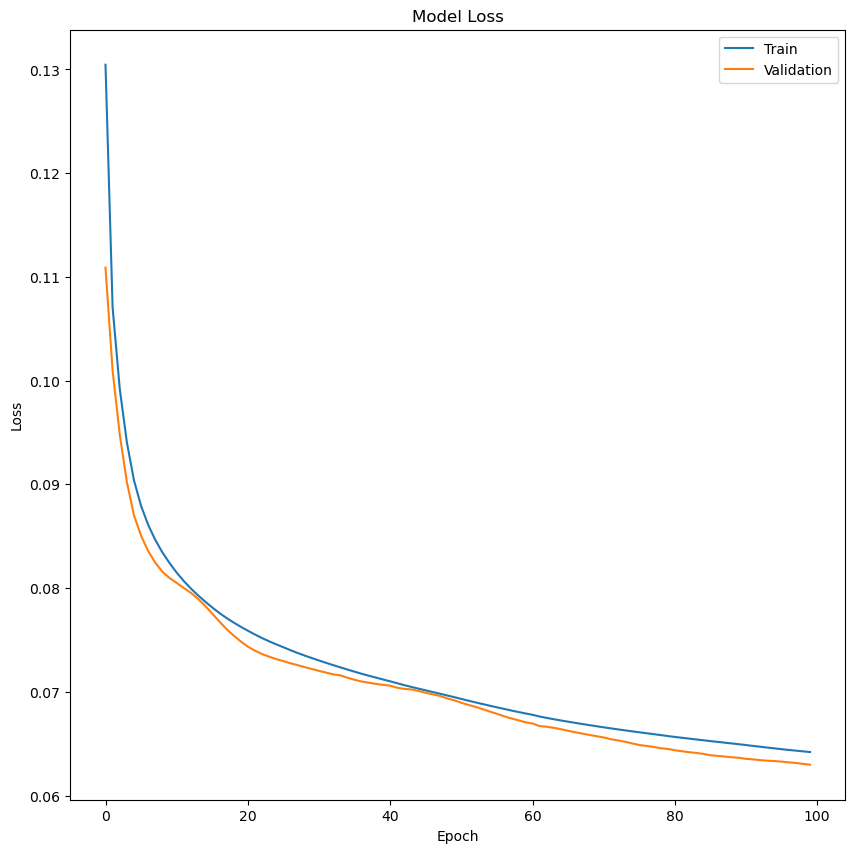

In [45]:
# plot model loss
plt.figure(figsize=(10,10))
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

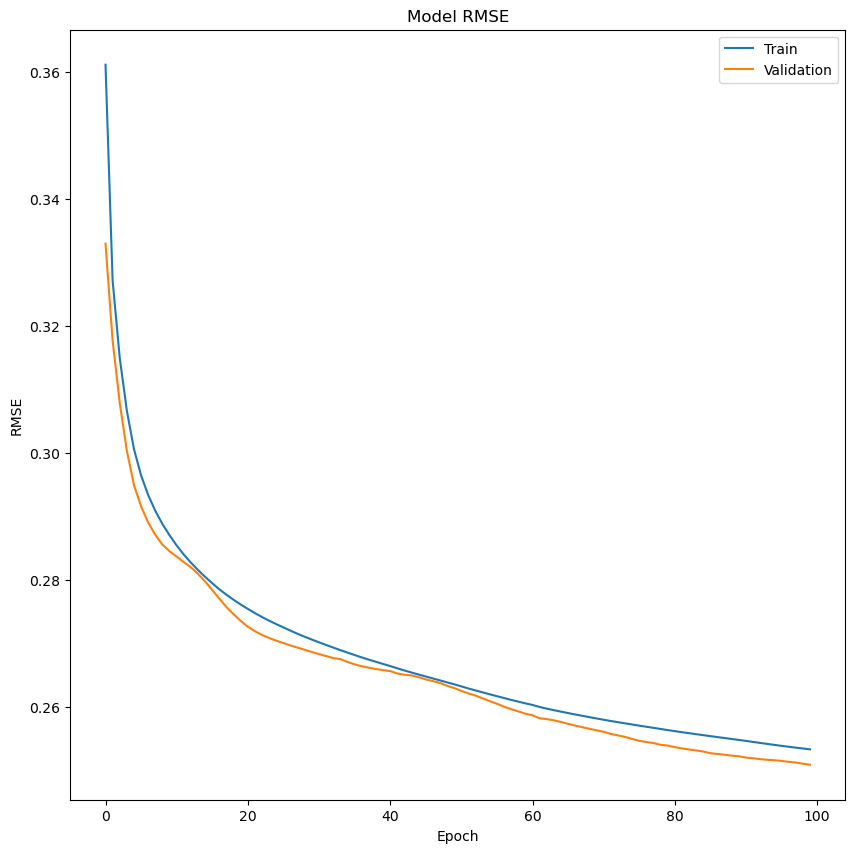

In [46]:
# plot model RMSE
plt.figure(figsize=(10,10))
plt.plot(history_model.history['root_mean_squared_error'])
plt.plot(history_model.history['val_root_mean_squared_error'])

plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate and Predict

In [47]:
# evaluate model
model.evaluate(x_test, y_test)

44243/44243 ━━━━━━━━━━━━━━━━━━━━ 17s 378us/step - loss: 0.0647 - root_mean_squared_error: 0.2545


[0.06489582359790802, 0.25474658608436584]

In [48]:
# make predictions
y_pred = model.predict(x_test)

44243/44243 ━━━━━━━━━━━━━━━━━━━━ 17s 374us/step


In [49]:
# join predictions and test data
df = pd.DataFrame(y_pred, columns=['y_pred'])
df['y_test'] = y_test
df['diff'] = df['y_pred'] - df['y_test']

# join df and x_test
df2 = pd.concat([df, x_test], axis=1)

df2.to_csv('predictions.csv', index=False)

In [50]:
df2.head()

,y_pred,y_test,diff,sea_level_pressure,site_id_mapped_BerkeleyCA,site_id_mapped_CardiffUK,site_id_mapped_CarletonOttawaCA,site_id_mapped_CornellNY,site_id_mapped_DublinIreland,site_id_mapped_LondonUK,...,month_dttm_March,month_dttm_May,month_dttm_November,month_dttm_October,month_dttm_September,square_feet,wind_speed,hour_dttm,air_temperature,dew_temperature
0,1.016811,NaN,NaN,0.438316,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.538664,-1.24,-0.090909,0.685526,0.846154
1,1.803938,NaN,NaN,-0.561684,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.061013,1.04,-0.818182,0.436842,0.490998
2,2.666067,NaN,NaN,1.500816,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.817064,0.00,0.000000,0.576316,0.590835
3,2.422186,NaN,NaN,0.625816,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.120965,-0.64,0.636364,0.586842,0.628478
4,1.241604,NaN,NaN,-0.311684,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.533545,-0.40,0.727273,0.518421,0.700491
